<img src="../../../notebook_banner.png" width="1024" style="float:center">
<div style="margin-top:10px; display:flex; align-items:center;">
    <div style="float:left; margin-right:10px;vertical-align:middle">
        <a href="https://www.linkedin.com/in/bruno-angles/" targer="_blank">
            <img src="../../../lkin-logo.png"/>
        </a>
    </div>
    <div> 
        Bruno Anglés (10/12/2022)
    </div>
 </div>

# Regresión lineal múltiple del dataset `insurance` (Kaggle)

En este ejercicio realizaremos un análisis del dataset de Kaggle `mirichoi0218/insurance`. 

El objetivo que perseguimos es el de formular algunas hipótesis para entrenar un algoritmo de regresión.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Configurar estilos de seaborn
sns.set()

## Importación del dataset

In [3]:
insurance = pd.read_csv("insurance.csv")

## Exploración del dataset

In [4]:
# Tamaño del dataset
insurance.shape

(1338, 7)

In [5]:
# Columnas y tipos de datos
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Variables numéricas**

- `age`: edad del beneficiario de la póliza
- `bmi`: índice de masa corporal del beneficiario de la póliza
- `children`: número de hijos cubiertos por la póliza
- `charges`: costes médicos facturados

**Variables categóricas**

- `sex`: sexo del beneficiario de la póliza
- `smoker`: Indica si el beneficiario es o no fumador
- `region`: área de residencia del beneficiario

In [6]:
# Mostrar estadísticas para las variables numéricas
insurance.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [7]:
age_min = int(insurance.age.min())
age_max = int(insurance.age.max())
print(f"La edad del beneficiario está entre los {age_min} y los {age_max}")

children_median = int(insurance.children.median())
children_max = int(insurance.children.max())
print(f"El promedio del número de hijos es de {children_median}, el máximo de {children_max}")

charges_min = float(insurance.charges.min())
charges_max = float(insurance.charges.max())
charges_range = charges_max - charges_min
charges_range_magnitude = math.floor(math.log(charges_range, 10))
print(f"La diferencia de los costes médicos tiene un orden de magnitud de {charges_range_magnitude},"
      f" de {charges_min:.2f} a {charges_max:.2f}")

La edad del beneficiario está entre los 18 y los 64
El promedio del número de hijos es de 1, el máximo de 5
La diferencia de los costes médicos tiene un orden de magnitud de 4, de 1121.87 a 63770.43


In [8]:
# Mostrar estadísticas para las variables categóricas
insurance.describe(include="object").transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [9]:
sex_values = set(insurance.sex.values)
print("sex:", sex_values)

smoker_values = set(insurance.smoker.values)
print("smoker:", smoker_values)

region_values = set(insurance.region.values)
print("region:", region_values)

sex: {'female', 'male'}
smoker: {'no', 'yes'}
region: {'southeast', 'southwest', 'northeast', 'northwest'}


## Limpieza del dataset

In [10]:
# Registros duplicados
shape_pre = insurance.shape
shape_post = insurance.drop_duplicates().shape
print("Tamaño del data set original:",shape_pre)
print("Tamaño del dataset sin duplicados:", shape_post)

if shape_pre != shape_post:
    print("Se han detectado registros duplicados, se van a eliminar")
    insurance = insurance.drop_duplicates()

Tamaño del data set original: (1338, 7)
Tamaño del dataset sin duplicados: (1337, 7)
Se han detectado registros duplicados, se van a eliminar


In [11]:
# Valores nulos
insurance.isnull().sum()

# No se han detectado valores nulos, por lo tanto no es necesario realizar una limpieza

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Visualización del dataset

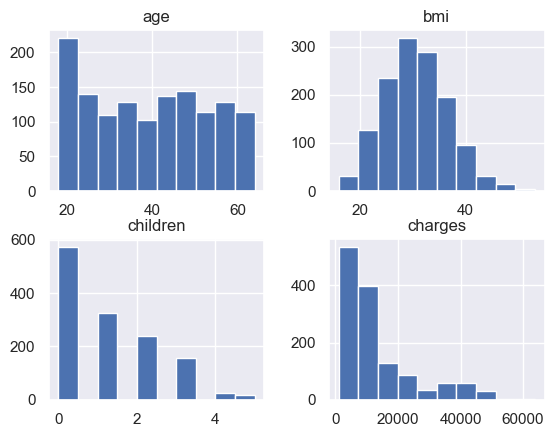

In [12]:
# Mostrar la distribución por columnas
insurance.hist()
plt.show()

- La vaiable `age` está distribuida de forma bastante uniforme aunque llama la atención la gran cantidad de beneficiarios que con edad menor o igual la 20 años, ya que [según un estudio](http://www.dgsfp.mineco.es/es/Publicaciones/DocumentosPublicaciones/Informe%20del%20Sector%202020.pdf) en España este tramo de edad sólo representa el `0,04%`.

In [13]:
total = len(insurance)
ins_by_age = insurance[["age", "charges"]].groupby("age").count()
ins_by_age["ratio"] = ins_by_age.charges.apply(lambda x: x / total).map('{:,.3f}%'.format)
ins_by_age.nlargest(3, "charges")

,charges,ratio
age,,
18,69,0.052%
19,67,0.050%
20,29,0.022%


- La variable `bmi` (índice de masa corporal) parece distribuirse de forma normal, tal como se esperaría.

- Respecto a la variable `children` vemos que el valor mayoritario es de cero lo cuál es coherente con lo que hemos visto respecto a la variable `age`. Ya que lo normal es que los menores de 20 años no tengan hijos.

In [14]:
ins_by_children = insurance[["children", "charges"]].groupby("children").count()
ins_by_children["ratio"] = ins_by_children.charges.apply(lambda x: x / total).map('{:,.3f}%'.format)
ins_by_children.nlargest(3, "charges")

,charges,ratio
children,,
0,573,0.429%
1,324,0.242%
2,240,0.180%


<div class="alert-block alert alert-info">
    <p style="font-weight: bold;">
        <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
        Variable children como categórica
    </p>
    <p>
        El patrón en columnas tan peculiar de la variable <i>children</i> podría ser categórica. Esto tendría el inconveniente de que el modelo no podría predecir el coste en el caso que el abonado tuviera más de 5 hijos.
    </p>
    <p>
        Para decidir si es conveniente consierararla categórica o no deberíamos investigar algo más. No obstante, dado que más adelante se considera que esta variable va a ser poco significativa de cara al modelo de regresión, se va a dejar como numérica.
    </p>
</div>

- Vemos que la mayoría de los costes médicos están por debajo de los `$20.000`. 

<div class="alert alert-block alert-info">
    <p style="font-weight: bold;">
        <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
        Variable objetivo
    </p>
    <p>
        Esta va a ser nuestra variable objetivo. El objetivo de este análisis es el de determinar qué variables pueden ser más significativas de cara a construir un modelo de regresión lineal capaz de predecir de la forma más eficaz posible el <strong>coste médico asociado a una determinada póliza</strong>
    </p>
</div>

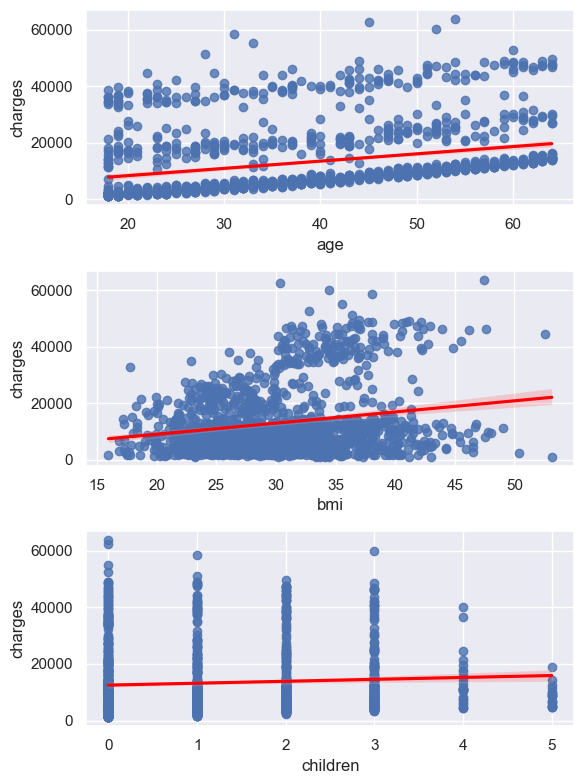

In [15]:
numerical_vars = insurance.columns[insurance.dtypes != "object"]
target = "charges"

fig, axes = plt.subplots(nrows=len(numerical_vars) - 1, ncols=1, figsize=(6,8))

for i, v in enumerate(numerical_vars):
    if v == target:
        continue
    sns.regplot(data=insurance, x=v, y=target, ax=axes[i], line_kws={"color":"red"}, fit_reg=True)
    
fig.tight_layout()

<a id="fact_num_estimators">[1]</a>
A la vista de los anteriores gráfcos, parece que tanto la *edad* (`age`) como el *índice de masa corporal* (`bmi`) son buenos predictores de los costes en salud (`charges`) . En cambio, el gráfico de dispersión tan característico de la variable *número de hijos* (`children`) sugiere que puede no ser un buen estimador. 

A continuación nos vamos a centrar en analizar cuál es el comportamiento de los *costos* en función del *número de hijos* 

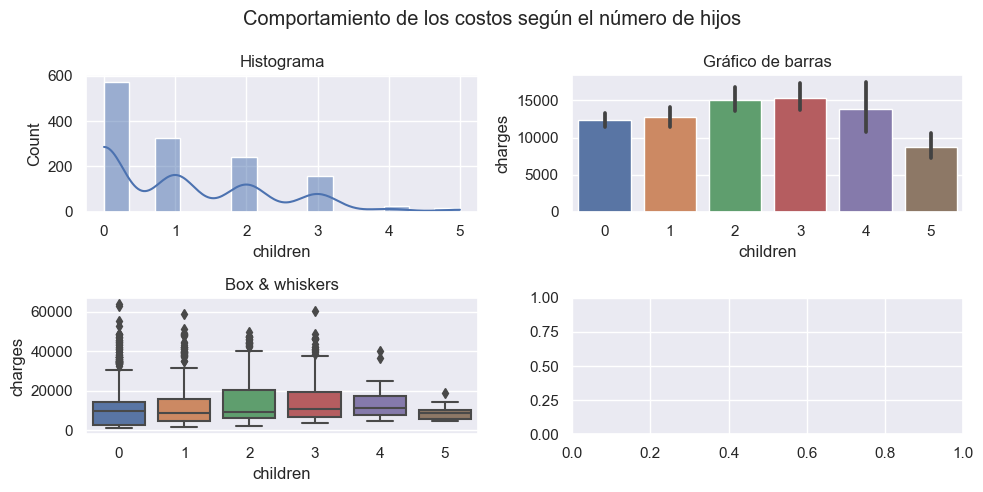

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

plt.suptitle("Comportamiento de los costos según el número de hijos")

ax1 = axes[0,0]
ax1.set_title("Histograma")
sns.histplot(insurance.children, kde=True, ax=ax1)

ax2 = axes[0,1]
ax2.set_title("Gráfico de barras")
sns.barplot(data=insurance, x="children", y="charges", ax=ax2)

ax3 = axes[1,0]
ax3.set_title("Box & whiskers")
sns.boxplot(data=insurance, x="children", y="charges", ax=ax3)
fig.tight_layout()

Estas visualizaciones confirman un poco lo visto en [[1]](#fact_num_estimators). Vemos que no hay apenas diferencia entre los valores más comunes para el *número de hijos* (0 y 1). La mayor diferencia la vemos en el caso de *5 hijos*, que es el caso menos frecuente.

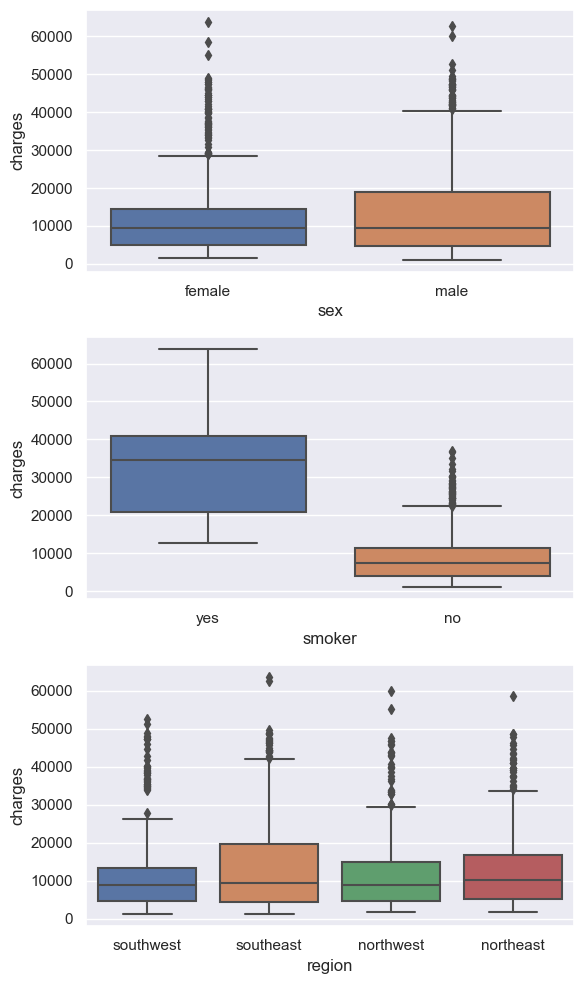

In [17]:
# Mostrar la distribución de los costes según las variables categóricas

categorical_vars = list(insurance.columns[insurance.dtypes == "object"])
target = "charges"

fig, axes = plt.subplots(nrows=len(categorical_vars), ncols=1, figsize=(6,10))

for i, v in enumerate(categorical_vars):
    sns.boxplot(data=insurance, y=target, x=v, ax=axes[i])
    
fig.tight_layout()

<a id="fact_cat_estimators">[2]</a>
A la vista de los gráficos anteriores, parece que el hecho de *ser o no fumador* (`smoker`) influye mucho en el importre de los *costes médicos* (`charges`) ya que el *coste promedio* es significativamente mayor en el caso de los fumadores.

En cambio no parece haber una gran diferencia respecto al *sexo* (`sex`) y el área geográfica (`region`).

Por [[1]](#fact_num_estimators) y [[2]](#fact_cat_estimators) parece interesante observar la dispersión de `charges` versus cada una de las variables numéricas, distinguiendo según `smoker`

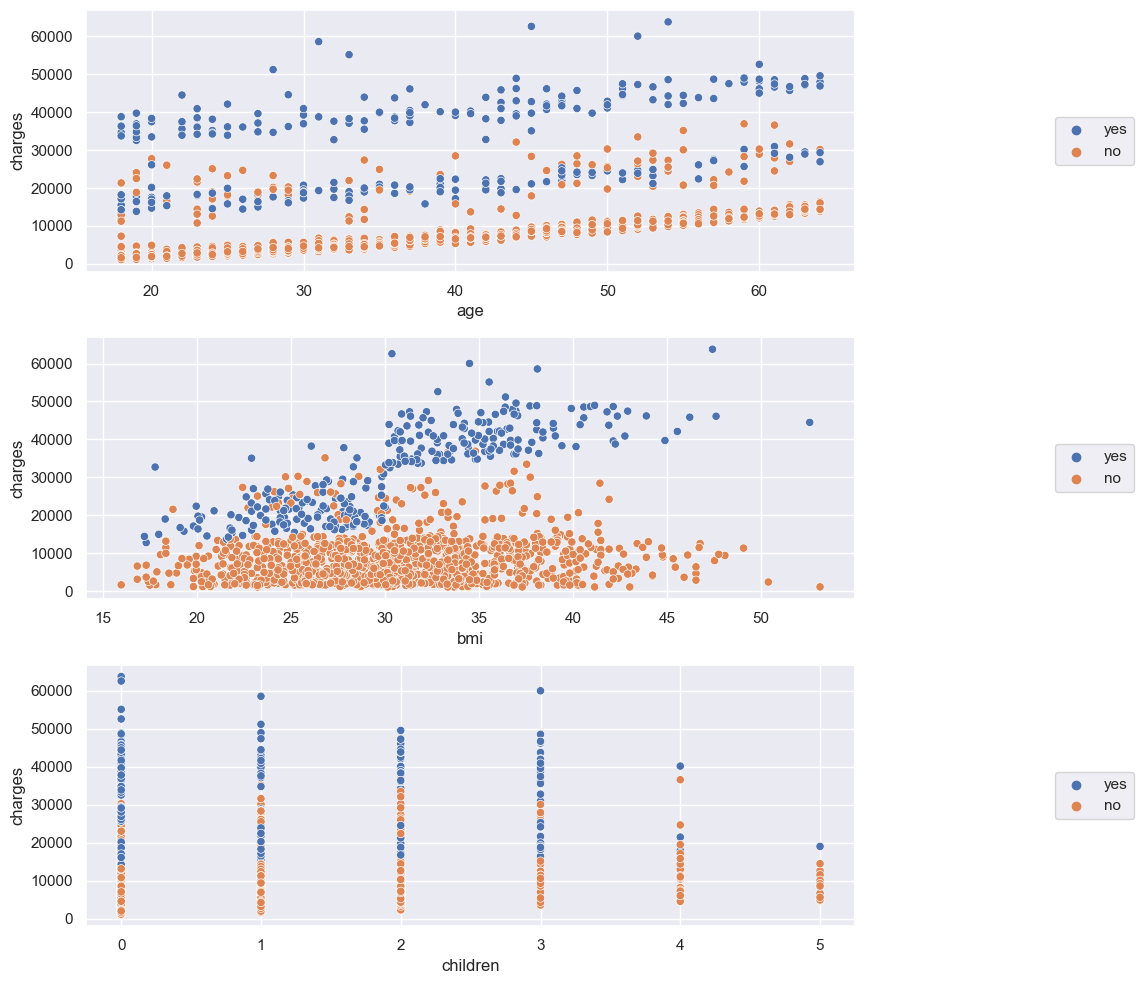

In [18]:
# Diagrama de dispersión de las variables numéricas en función de la variable smoker
fig, axes = plt.subplots(nrows=len(numerical_vars) - 1, ncols=1, figsize=(12,10))

for i, v in enumerate(numerical_vars):
    if v == target:
        continue
    g = sns.scatterplot(data=insurance, x=v, y=target, ax=axes[i], hue="smoker")
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
fig.tight_layout()
    

<a id="fact_smoker_estimator">[3]</a>
A la vista de los gráficos anteriores, parece que la variable `smoker` separa muy bien los datos, con lo que puede ser un buen estimador de los *costes* (`charges`)

/var/folders/jy/88_thsfj3xx4wvtlz4y08p6m7s11b_/T/ipykernel_59511/3715858277.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = insurance.corr()


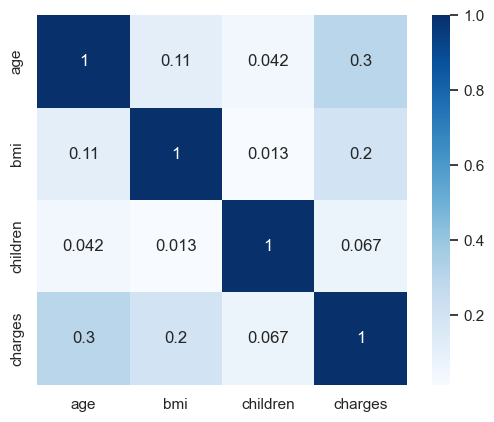

In [19]:
# Diagrama de correlación
corr = insurance.corr()
sns.heatmap(corr, cmap="Blues", annot=True, square=True)
plt.show()

El diagrama de correlación confirma la intuición que teníamos en [[1]](#fact_num_estimators), de que `charges` tiene una correlación moderada con `age` y `bmi`.

<a id="fact_corr_age_bmi">[4]</a>
También vemos una correlación algo más débil entre `age` y `bmi`. Esta correlación es directa e indicaría que el *a mayor edad mayor índice de masa corporal*

# Hipótesis para entrenar un modelo de regresión

Planteamos un modelo de **regresión múltiple** para predecir los costes médicos de una determinada póliza (`charges`).

Para ello proponemos las siuguientes hipótesis de trabajo.

- **Hipótesis 1**: entrenar el modelo sólo con las variables numéricas
    - **Hipótesis 1 (b)**: escalar el valor de `charges`
- **Hipótesis 2**: usar tanto las variables numéricas como las categóricas (mediante *one hot encodding*) para entrenar el modelo
    - **Hipótesis 2 (b)**: escalar el valor de `charges`
- **Hipótesis 3**: entrenar el modelo sólo con las variables que hemos encontrado significativas en [[1]](#fact_num_estimators), [[2]](#fact_cat_estimators) y [[3]](#fact_smoker_estimator): `age, bmi, smoker`
    - **Hipótesis 3 (b)**: escalar el valor de `charges`
- **Hipótesis 4**: entrenar un modelo super-reducido teniendo en cuenta sólo `bmi`y `smoker`para predecir `charges`. En en este modelo eliminaríamos la variable `age` ya que según [[4]](#fact_corr_age_bmi) hay una ligera correlación entre la *edad* y el *índice de masa corporal*.
    - **Hipótesis 4 (b)**: escalar el valor de `charges`


# Entrenamiento del modelo de regresión lineal múltiple

In [20]:
class Hypotesis:
    def __init__(self):
        self.model = None            # El modelo de regresión lineal entrenado
        self.coefficients = None     # Coeficientes de la regresión
        self.fitted_values = None    # Predicciones del modelo sobre los datos de entrenamiento
        self.test_predictions = None # Predicciones del modelo sobre los datos de test
        self.scaler = None           # Si usamos escalado, el scaler empledado
        self.mse_train = None        # Error cuadrático medio sobre los datos de entrenamienti
        self.mse_test = None         # Error cuadrático medio sobre los datos de test
        num_features = None          # Número de variables usadas para el entrenamiento
        
    def train_model(self, X, y, scaler=None):
        self.num_features = X.shape[1]
        # [Opcional] escalamos la variable objetivo
        if scaler is not None:
            y_sca = scaler.fit_transform(y.to_numpy().reshape(-1, 1)).reshape(1, -1)[0]
        # Separamos el dataset en conjunto de entrenamiento y de test
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y.to_numpy() if scaler is None else y_sca, 
            test_size=0.2, random_state=2001
        )
        print(f"Training set. X: {X_train.shape}, y:{y_train.shape}")
        print(f"Test set. X: {X_test.shape}, y:{y_test.shape}")
        
        # Entrenamos el modelo
        self.model = LinearRegression()
        self.model.fit(X_train, y_train)
        
        # Almacenamos resultados del entrenamiento
        self.coefficients = pd.DataFrame({
            "feature": np.array(X.columns),
            "slope": self.model.coef_
        }).set_index("feature", drop=True)
        self.fitted_values = self.model.predict(X_train)
        self.test_predictions = self.model.predict(X_test)
        
        
        # Evaluamos el modelo
        self.mse_train = mean_squared_error(y_true=y_train, y_pred=self.fitted_values)
        print("TRAIN MSE:", self.mse_train)
        self.mse_test = mean_squared_error(y_true=y_test, y_pred=self.test_predictions)
        print("TEST_MSE:", self.mse_test)

In [21]:
# Diccionario en el que almacenaremos las hipótesis que vayamos probando
my_hypotesis = dict()

## Hipótesis 1. Variables numéricas

In [22]:
# Preparamos el dataset para la hipótesis 1

data_hyp01 = insurance[numerical_vars]
X_hyp01 = data_hyp01.drop(target, axis=1)
y_hyp01 = data_hyp01[target]

print("X shape", X_hyp01.shape)
print("y shape", y_hyp01.shape)

X shape (1337, 3)
y shape (1337,)


In [23]:
# Probamos la hipótesis
hyp01 = Hypotesis()
hyp01.train_model(X=X_hyp01, y=y_hyp01)
my_hypotesis["Hipótesis 1"] = hyp01

Training set. X: (1069, 3), y:(1069,)
Test set. X: (268, 3), y:(268,)
TRAIN MSE: 131097605.74437317
TEST_MSE: 121379843.75361224


### Hipótesis 1b. Escalando `charges`

In [24]:
# Probamos la hipótesis con los mismos datos

hyp01_sca = Hypotesis()
hyp01_sca.train_model(X=X_hyp01, y=y_hyp01, scaler=MinMaxScaler())
my_hypotesis["Hipótesis 1b"] = hyp01_sca

Training set. X: (1069, 3), y:(1069,)
Test set. X: (268, 3), y:(268,)
TRAIN MSE: 0.033402014158649004
TEST_MSE: 0.03092605114038686


## Hipótesis 2. Usar todas las variables

In [25]:
# Preparamos el dataset para la hipótesis 2

data_hyp02 = pd.get_dummies(
    data=insurance,
    columns=categorical_vars,
    drop_first=False,
    dtype="int8",
    
).drop(["sex_male", "smoker_no"], axis=1)

X_hyp02 = data_hyp02.drop(target, axis=1)
y_hyp02 = data_hyp02[target]

print(X_hyp02.columns)
print("X shape", X_hyp02.shape)
print("y shape", y_hyp02.shape)

Index(['age', 'bmi', 'children', 'sex_female', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')
X shape (1337, 9)
y shape (1337,)


In [26]:
# Probamos la hipótesis
hyp02 = Hypotesis()
hyp02.train_model(X=X_hyp02, y=y_hyp02)
my_hypotesis["Hipótesis 2"] = hyp02

Training set. X: (1069, 9), y:(1069,)
Test set. X: (268, 9), y:(268,)
TRAIN MSE: 36995296.6708089
TEST_MSE: 34833563.30301585


### Hipótesis 2b. Escalando `charges`

In [27]:
# Probamos la hipótesis con los mismos datos

hyp02_sca = Hypotesis()
hyp02_sca.train_model(X=X_hyp02, y=y_hyp02, scaler=MinMaxScaler())
my_hypotesis["Hipótesis 2b"] = hyp02_sca

Training set. X: (1069, 9), y:(1069,)
Test set. X: (268, 9), y:(268,)
TRAIN MSE: 0.00942593433484438
TEST_MSE: 0.00887515197579015


## Hipótesis 3. Entrenar el modelo sólo con las variables `age, bmi, smoker`

In [28]:
# Preparamos el dataset para la hipótesis 3

# Vamos a partir del dataset de la hipótesis 2 ya que ya tenemos condificada la variable categórica smoker

data_hyp03 = data_hyp02[["age", "bmi", "smoker_yes", "charges"]]

X_hyp03 = data_hyp03.drop(target, axis=1)
y_hyp03 = data_hyp03[target]

print("X shape", X_hyp03.shape)
print("y shape", y_hyp03.shape)

X shape (1337, 3)
y shape (1337,)


In [29]:
# Probamos la hipótesis
hyp03 = Hypotesis()
hyp03.train_model(X=X_hyp03, y=y_hyp03)
my_hypotesis["Hipótesis 3"] = hyp03

Training set. X: (1069, 3), y:(1069,)
Test set. X: (268, 3), y:(268,)
TRAIN MSE: 37530339.72410131
TEST_MSE: 35178742.834781006


### Hipótesis 3b. Escalando `charges`

In [30]:
# Probamos la hipótesis con los mismos datos

hyp03_sca = Hypotesis()
hyp03_sca.train_model(X=X_hyp03, y=y_hyp03, scaler=MinMaxScaler())
my_hypotesis["Hipótesis 3b"] = hyp03_sca

Training set. X: (1069, 3), y:(1069,)
Test set. X: (268, 3), y:(268,)
TRAIN MSE: 0.00956225654713869
TEST_MSE: 0.008963099360807823


## Hipótesis 4. Entrenar el modelo sólo con las variables `bmi, smoker`

In [31]:
# Preparamos el dataset para la hipótesis 4

# Vamos a partir del dataset de la hipótesis 2 ya que ya tenemos condificada la variable categórica smoker

data_hyp04 = data_hyp02[["bmi", "smoker_yes", "charges"]]

X_hyp04 = data_hyp04.drop(target, axis=1)
y_hyp04 = data_hyp04[target]

print("X shape", X_hyp04.shape)
print("y shape", y_hyp04.shape)

X shape (1337, 2)
y shape (1337,)


In [32]:
# Probamos la hipótesis
hyp04 = Hypotesis()
hyp04.train_model(X=X_hyp04, y=y_hyp04)
my_hypotesis["Hipótesis 4"] = hyp04

Training set. X: (1069, 2), y:(1069,)
Test set. X: (268, 2), y:(268,)
TRAIN MSE: 51206877.49565099
TEST_MSE: 45963336.03205973


### Hipótesis 4b. Escalando `charges`

In [33]:
# Probamos la hipótesis con los mismos datos

hyp04_sca = Hypotesis()
hyp04_sca.train_model(X=X_hyp04, y=y_hyp04, scaler=MinMaxScaler())
my_hypotesis["Hipótesis 4b"] = hyp04_sca

Training set. X: (1069, 2), y:(1069,)
Test set. X: (268, 2), y:(268,)
TRAIN MSE: 0.013046865634335603
TEST_MSE: 0.011710877496231434


# Evaluar los distintos modelos de regresión entrenados

In [34]:
# Resumen de los determinados errores obtenidos

name_list = np.array(my_hypotesis.keys())
mse_train_list = np.array([h.mse_train for h in my_hypotesis.values()])
mse_test_list = np.array([h.mse_test for h in my_hypotesis.values()])

errors = pd.DataFrame(
 {"name": name_list, "mse_train": mse_train_list, "mse_test":mse_test_list}   
)


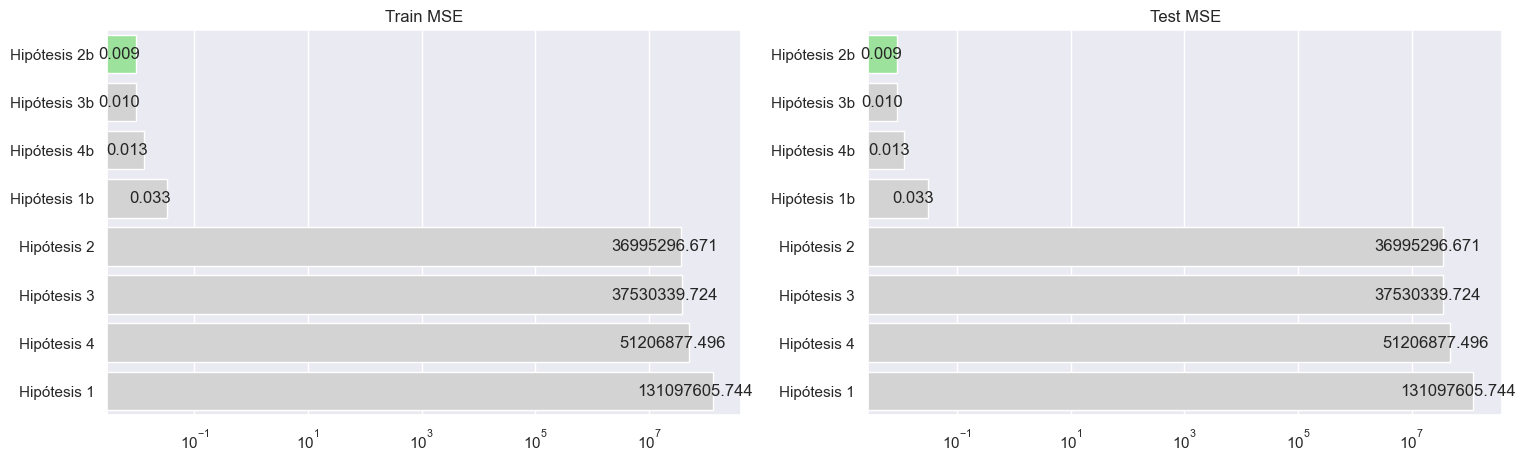

In [35]:
# Visualización de los distintos errores

fif, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

plt_train = axes[0]
plt_train.set_title("Train MSE")

plt_test = axes[1]
plt_test.set_title("Test MSE")

sns.barplot(
    ax=plt_train, 
    data=errors.nsmallest(len(errors), "mse_train"),
    y="name", x="mse_train",
    palette=["lightgreen"] + ["lightgrey"]*(len(errors) - 1),
).set(xlabel="", ylabel="")

plt_train.bar_label(plt_train.containers[0],fmt='%.3f', label_type='center')

sns.barplot(
    ax=plt_test, 
    data=errors.nsmallest(len(errors), "mse_test"),
    y="name", x="mse_test",
    palette=["lightgreen"] + ["lightgrey"]*(len(errors) - 1)
).set(xlabel="", ylabel="")
plt_test.bar_label(plt_train.containers[0],fmt='%.3f', label_type='center')
   

plt_train.set_xscale("log")
plt_test.set_xscale("log")

fig.tight_layout(pad=10.0)

<div class="alert alert-success">
    La Hipótesis 2b es la mejor, formulada como:
    <blockquote>
        Usar todas las variables proporcionadas, codificando las variables categóricas mediante la técnica <em>One Hot Encoding</em> y escalando la variable objetivo (<em>charges</em>).
    </blockquote>
</div>

# Conclusiones

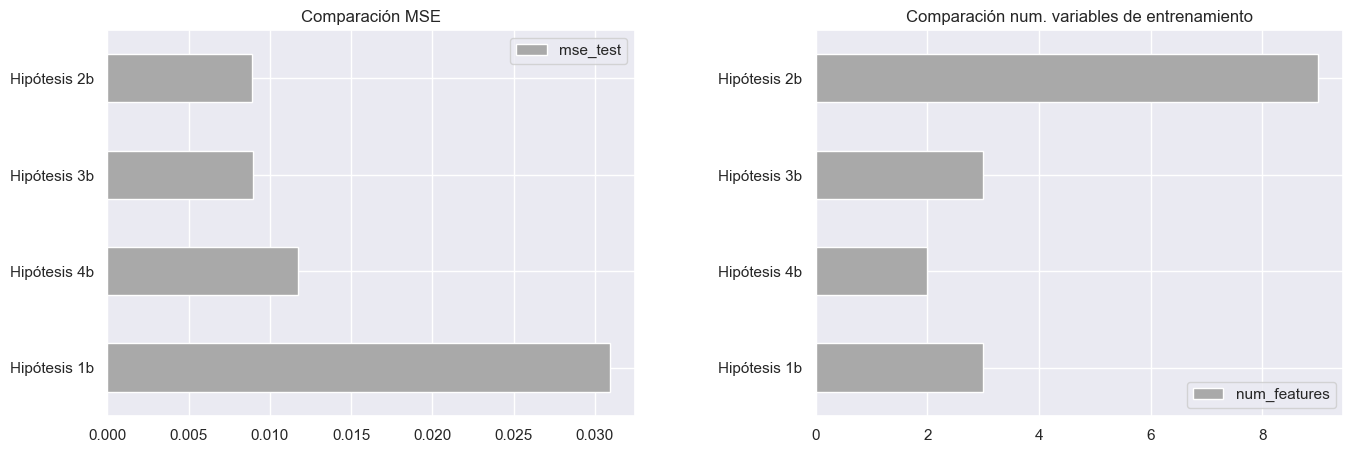

In [77]:
best_models = [(n, h.num_features, h.mse_test) for n,h in my_hypotesis.items() if n.endswith("b") ]
df = (
    pd.DataFrame(best_models, columns=["Hypotesis", "num_features", "mse_test"])
    .set_index("Hypotesis", drop=True)
    .sort_values("mse_test", ascending=False)
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
axes[0].set_title("Comparación MSE")
axes[1].set_title("Comparación num. variables de entrenamiento")


df[["mse_test"]].plot(kind="barh", ax=axes[0], color="darkgrey")
df[["num_features"]].plot(kind="barh", ax=axes[1], color="darkgrey")

for ax in axes:
    ax.set_ylabel("")

plt.tight_layout(pad=5.0)

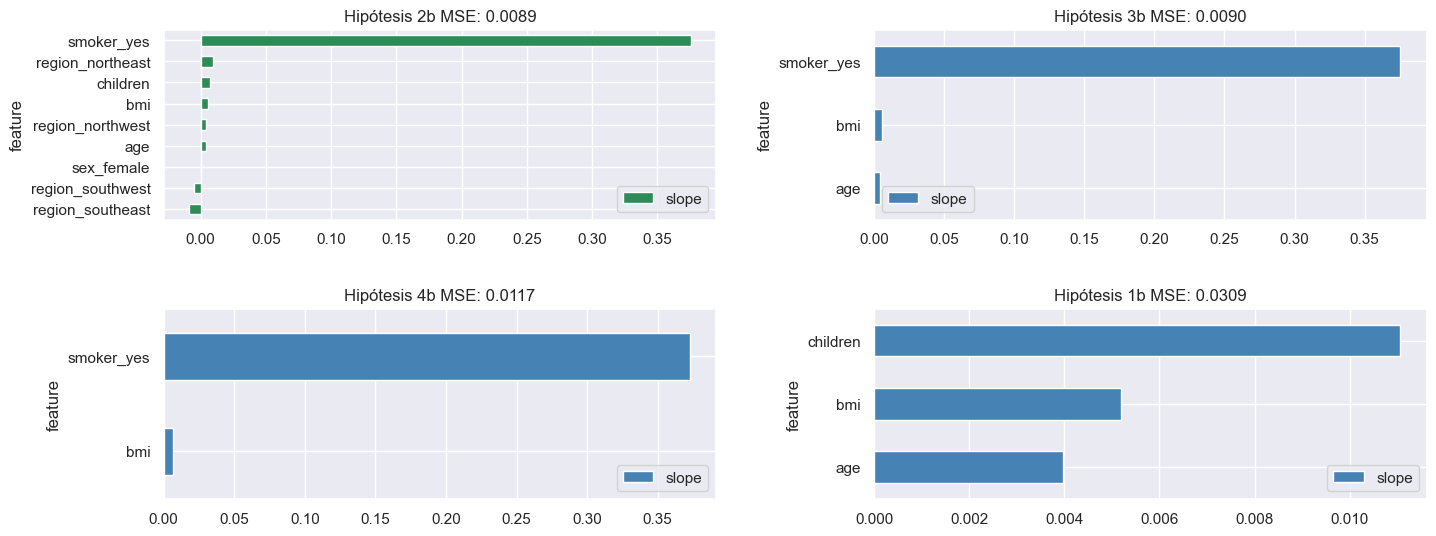

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6))

coef_list = [(n,h.coefficients, h.mse_test) for n,h in my_hypotesis.items() if n.endswith("b")]
coef_list = sorted(coef_list, key=lambda x: x[2])

for i, t in enumerate(coef_list):
    name, coef, mse_test = t
    color = "seagreen" if i==0 else "steelblue"
    ax = axes[math.floor(i/2)][i%2]
    ax.set_title(f"{name} MSE: {mse_test:.4f}")
    coef = coef.sort_values("slope", ascending=True)
    coef.plot(kind="barh", ax=ax, color=color)
    
fig.tight_layout(pad=2.5)